In [1]:
import os
import pandas as pd
import geopandas as gpd

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32636
# path to data
example_data_path = "./data"

In [2]:
# load aggregated info we have
aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

In [3]:
# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet")).rename_geometry('geometry')

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

# services should be specified as a dictionary
services = {"kindergartens": kindergartens}

In [4]:
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas,
            "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

In [5]:
from masterplan_tools import CityModel

city_model = CityModel(
  blocks=aggregated_blocks, 
  accessibility_matrix=accessibility_matrix, 
  services=services
)

In [6]:
from masterplan_tools import ProvisionModel

services_prov = {}

for service_type in city_model.get_service_types():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    services_prov[service_type] = provision.run(overflow=True)
    print(service_type)

schools
kindergartens
recreational_areas
hospitals
pharmacies
policlinics


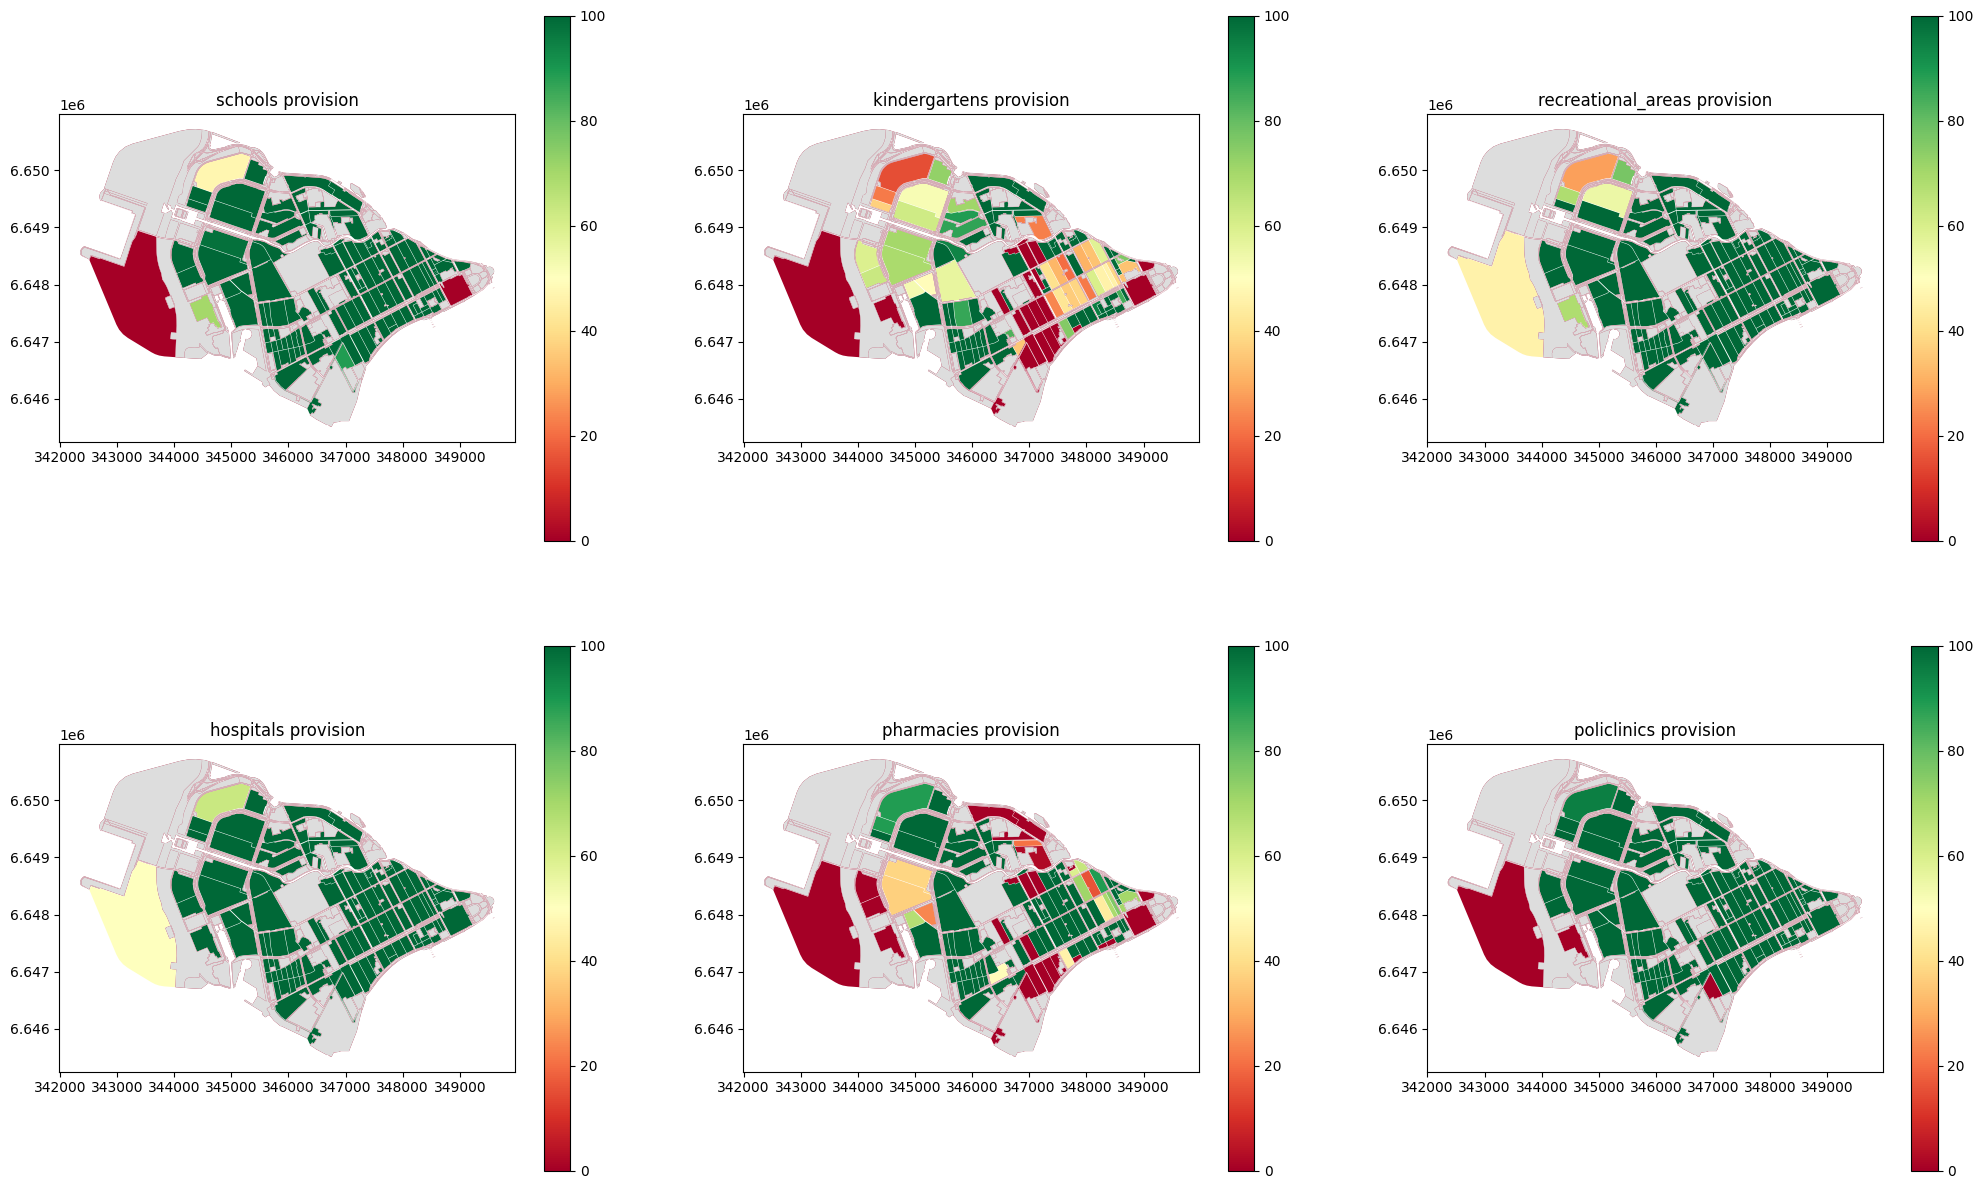

In [7]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def show_me_chart(fig, gs, prov, name, i):
  ax = fig.add_subplot(gs[i//3, i%3])
  prov.plot(column="provision_"+name, legend=True, ax=ax, cmap='RdYlGn')
  ax.set_title(name +" provision")
  prov[prov["population"] == 0].plot(ax=ax, color="#ddd", alpha=1)

fig = plt.figure(figsize=(25, 15))
gs = GridSpec(2, 3, figure=fig)

i = 0
for service_type in services_prov:
  show_me_chart(fig, gs, services_prov[service_type], service_type, i)
  i = i+1

plt.show()


In [8]:
for service_type in city_model.get_service_types():
    dem = services_prov[f'{service_type}'][f"demand_{service_type}"].sum()
    prov = services_prov[f'{service_type}'][f"population_prov_{service_type}"].sum()
    score = prov/dem
    print(f'{service_type} = {score : .3f}')


schools =  0.876
kindergartens =  0.477
recreational_areas =  0.879
hospitals =  1.000
pharmacies =  0.651
policlinics =  0.896


In [9]:
updated_block = {'block_id': 242,
  'population': 0,
  'is_kindergartens_service': 1,
  'kindergartens_capacity': 500}

In [10]:
graph_base = city_model.services_graph.copy()
graph = graph_base.copy()

if updated_block['block_id'] in graph.nodes:
    for attr_name, attr_value in updated_block.items():
        if attr_name in graph.nodes[updated_block['block_id']]:
            graph.nodes[updated_block['block_id']][attr_name] += attr_value

city_model.services_graph = graph

services_prov = {}
for service_type in city_model.get_service_types():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    services_prov[service_type] = provision.run(overflow=True)
    print(service_type)

city_model.services_graph = graph_base

schools
kindergartens
recreational_areas
hospitals
pharmacies
policlinics


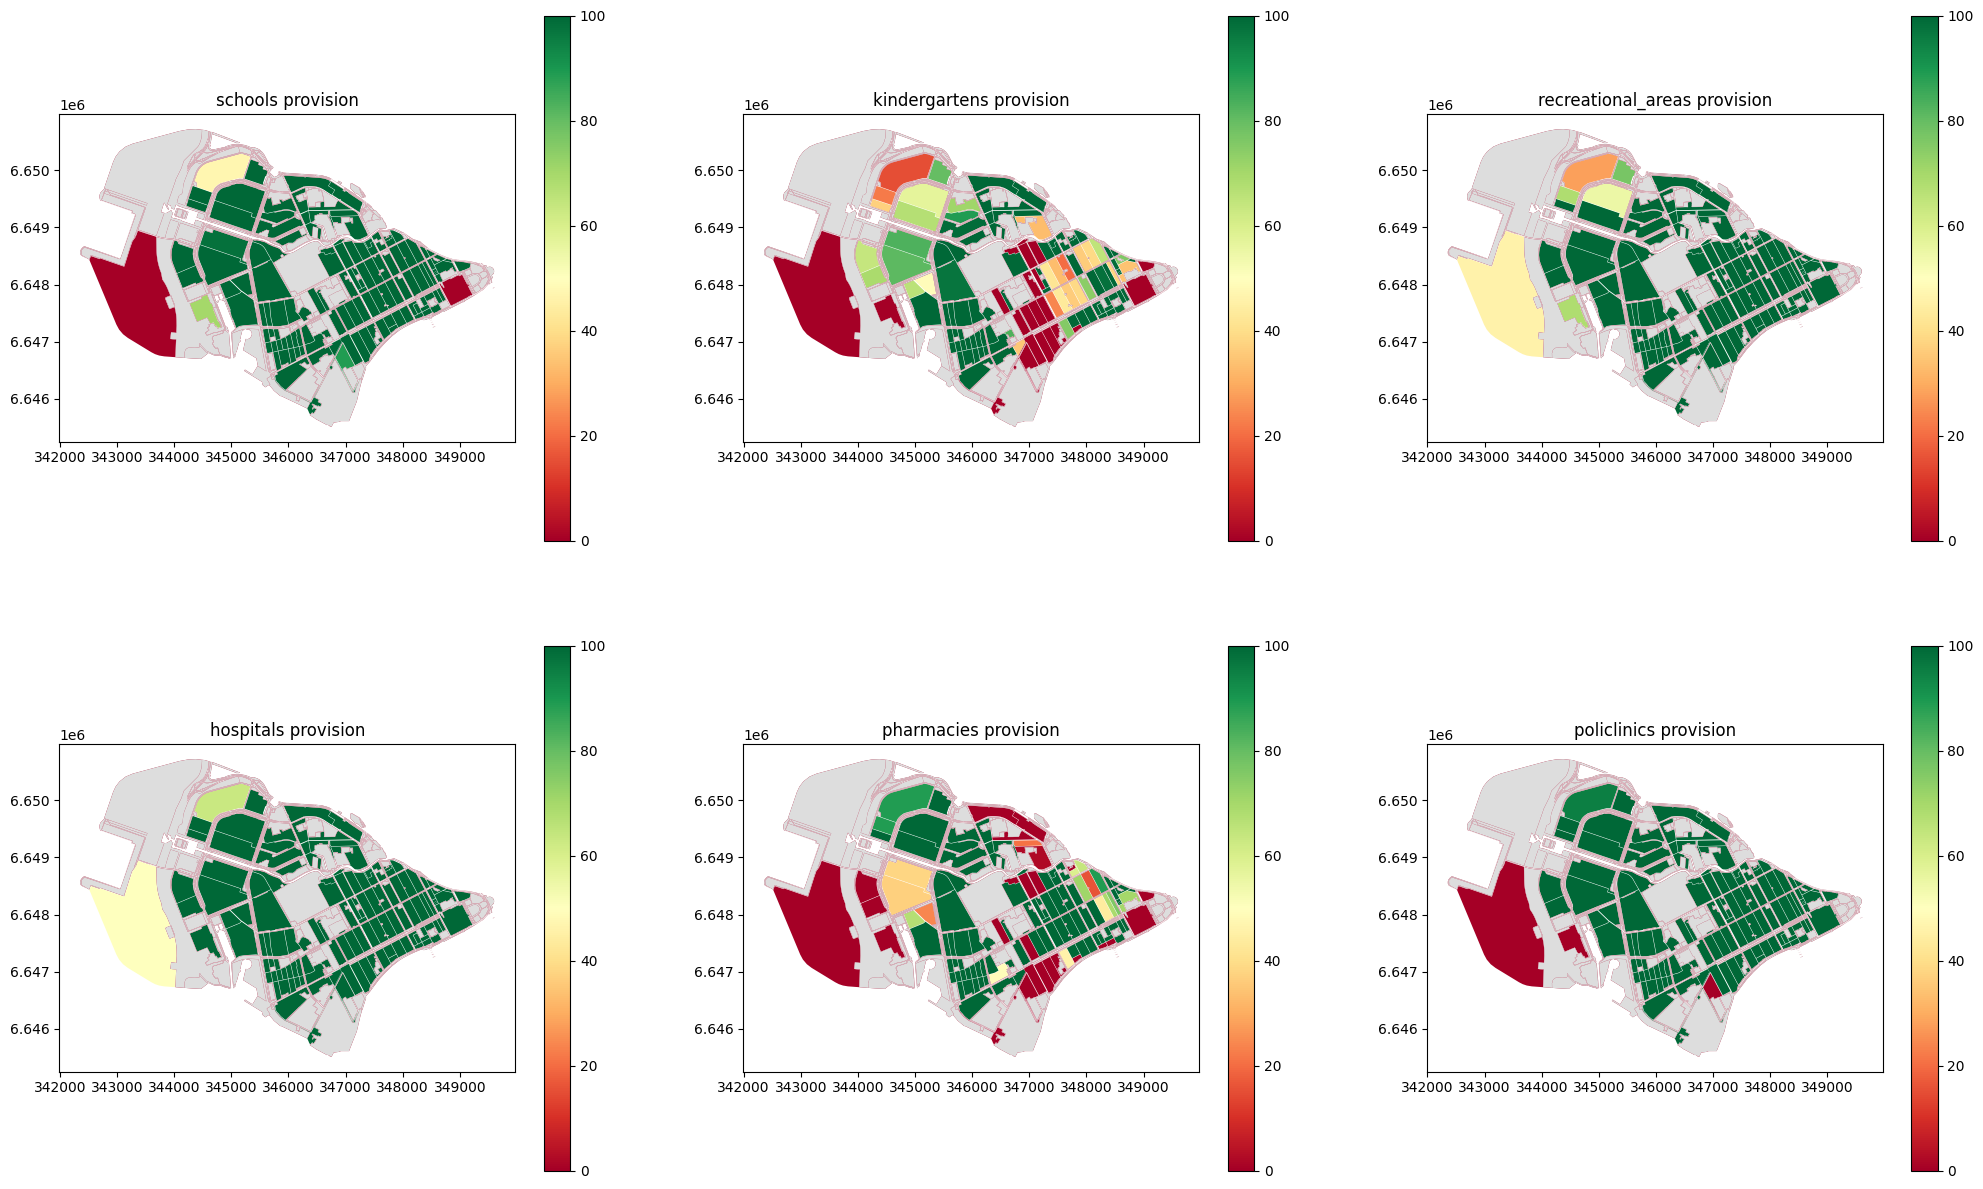

In [11]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def show_me_chart(fig, gs, prov, name, i):
  ax = fig.add_subplot(gs[i//3, i%3])
  prov.plot(column="provision_"+name, legend=True, ax=ax, cmap='RdYlGn')
  ax.set_title(name +" provision")
  prov[prov["population"] == 0].plot(ax=ax, color="#ddd", alpha=1)

fig = plt.figure(figsize=(25, 15))
gs = GridSpec(2, 3, figure=fig)

i = 0
for service_type in services_prov:
  show_me_chart(fig, gs, services_prov[service_type], service_type, i)
  i = i+1

plt.show()

In [12]:
for service_type in city_model.get_service_types():
    dem = services_prov[f'{service_type}'][f"demand_{service_type}"].sum()
    prov = services_prov[f'{service_type}'][f"population_prov_{service_type}"].sum()
    score = prov/dem
    print(f'{service_type} = {score : .3f}')

schools =  0.876
kindergartens =  0.531
recreational_areas =  0.879
hospitals =  1.000
pharmacies =  0.651
policlinics =  0.896
